In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import stats
from collections import deque
from scipy.optimize import minimize
from scipy.linalg import norm, inv, det, eig
import time
import seaborn as sns
import pickle
sns.set_theme()
np.set_printoptions(precision=2)

In [2]:
def fill_square_matrix(K):
    res = np.empty((K, K))
    for i in range(K):
        for j in range(K):
            val = input("%s %s" % (i + 1, j + 1))
            res[i, j] = val
    return res


def fill_column_vector(K):
    res = np.empty((K, 1))
    for i in range(K):
        val = input("%s 1" % (i + 1))
        res[i, 0] = val
    return res


class multivariate_exponential_hawkes(object):
    """
    Multivariate Hawkes process with exponential kernel. No events nor initial conditions considered.
    """

    def __init__(self, mu, alpha, beta, max_jumps=None, max_time=None):
        """

        Parameters
        ----------
        mu : array_like
            Baseline intensity vector. mu.shape[0] must coincide with shapes for alpha and beta.
        alpha : array_like
            Interaction factors matrix. Must be a square array with alpha.shape[0] coinciding with mu and beta.
        beta : array_like
            Decay factor matrix. Must be either an array. When corresponding to decay for each process i, it must
            be of shape (number_of_process, 1), or a square array. beta.shape[0] must coincide with mu and alpha.
        max_jumps : float, optional
            Maximal number of jumps. The default is None.
        max_time : float, optional
            Maximal time horizon. The default is None.

        Attributes
        ----------
        nb_processes : int
            Number of dimensions.
        timestamps : list of tuple (float, int)
            List of simulated events and their marks.
        intensity_jumps : array of float
            Array containing all intensities at each jump. It includes the baseline intensities mu.
        simulated : bool
            Parameter that marks if a process has been already been simulated,
            or if its event times have been initialized.

        """

        # We must begin by verifying that the process is a point process. In other words, that the number of
        # points in any bounded interval is a.s. finite. For this, we have to verify that the spectral radius of
        # the matrix alpha/beta (term by term) is <1.

        beta_radius = np.copy(beta)
        beta_radius[beta_radius == 0] = 1
        spectral_radius = np.max(np.abs(np.linalg.eig(np.abs(alpha) / beta_radius)[0]))

        if spectral_radius >= 1:
            # raise ValueError("Spectral radius is %s, which makes the process unstable." % (spectral_radius))
            warnings.warn("Spectral radius is %s, which makes the process unstable." % (spectral_radius),RuntimeWarning)
        self.mu = mu.reshape((alpha.shape[0], 1))
        self.alpha = alpha
        self.beta = beta
        self.max_jumps = max_jumps
        self.max_time = max_time

        self.nb_processes = self.mu.shape[0]
        self.count = np.zeros(self.nb_processes, dtype=int)

        self.timestamps = [(0.0, 0)]
        self.intensity_jumps = np.copy(mu)

        self.simulated = False

    def simulate(self):
        """
        Auxiliary function to check if already simulated and, if not, which simulation to launch.

        Simulation follows Ogata's adapted thinning algorithm. Upper bound obtained by the positive-part process.

        Works with both self-exciting and self-regulating processes.

        To launch simulation either self.max_jumps or self.max_time must be other than None, so the algorithm knows when to stop.
        """
        if not self.simulated:
            if self.max_jumps is not None and self.max_time is None:
                self.simulate_jumps()
            elif self.max_time is not None and self.max_jumps is None:
                self.simulate_time()
            else:
                print("Either max_jumps or max_time must be given.")
            self.simulated = True

        else:
            print("Process already simulated")

    def simulate_jumps(self):
        """
        Simulation is done until the maximal number of jumps (self.max_jumps) is attained.
        """
        flag = 0
        t = 0

        auxiliary_alpha = np.where(self.alpha > 0, self.alpha, 0)
        auxiliary_ij = np.zeros((self.nb_processes, self.nb_processes))
        auxiliary_intensity = np.copy(self.mu)

        ij_intensity = np.zeros((self.nb_processes, self.nb_processes))

        while flag < self.max_jumps:

            upper_intensity = np.sum(auxiliary_intensity)

            previous_t = t
            t += np.random.exponential(1 / upper_intensity)

            # ij_intensity = np.multiply(ij_intensity, np.exp(-self.beta * (t - self.timestamps[-1][0])))
            ij_intensity = np.multiply(ij_intensity, np.exp(-self.beta * (t - previous_t)))
            candidate_intensities = self.mu + np.sum(ij_intensity, axis=1, keepdims=True)
            pos_candidate = np.maximum(candidate_intensities, 0) / upper_intensity
            type_event = np.random.multinomial(1, np.concatenate((pos_candidate.squeeze(), np.array([0.0])))).argmax()
            if type_event < self.nb_processes:
                self.timestamps += [(t, type_event + 1)]
                ij_intensity[:, type_event] += self.alpha[:, type_event]
                self.intensity_jumps = np.c_[
                    self.intensity_jumps, self.mu + np.sum(ij_intensity, axis=1, keepdims=True)]

                auxiliary_ij = np.multiply(auxiliary_ij, np.exp(-self.beta * (t - self.timestamps[-2][0])))
                auxiliary_ij[:, type_event] += auxiliary_alpha[:, type_event]
                auxiliary_intensity = self.mu + np.sum(auxiliary_ij, axis=1, keepdims=True)

                flag += 1

                self.count[type_event] += 1

        self.max_time = self.timestamps[-1][0]
        # Important to add the max_time for plotting and being consistent.
        self.timestamps += [(self.max_time, 0)]

    def simulate_time(self):
        """
        Simulation is done for a window [0, T] (T = self.max_time) is attained.
        """
        t = 0
        flag = t < self.max_time

        auxiliary_alpha = np.where(self.alpha > 0, self.alpha, 0)
        auxiliary_ij = np.zeros((self.nb_processes, self.nb_processes))
        auxiliary_intensity = np.copy(self.mu)

        ij_intensity = np.zeros((self.nb_processes, self.nb_processes))

        while flag:

            upper_intensity = np.sum(auxiliary_intensity)

            previous_t = t
            t += np.random.exponential(1 / upper_intensity)

            # ij_intensity = np.multiply(ij_intensity, np.exp(-self.beta * (t - self.timestamps[-1][0])))
            ij_intensity = np.multiply(ij_intensity, np.exp(-self.beta * (t - previous_t)))
            candidate_intensities = self.mu + np.sum(ij_intensity, axis=1, keepdims=True)
            pos_candidate = np.maximum(candidate_intensities, 0) / upper_intensity
            type_event = np.random.multinomial(1,
                                               np.concatenate((pos_candidate.squeeze(), np.array([0.0])))).argmax()
            flag = t < self.max_time
            if type_event < self.nb_processes and flag:
                self.timestamps += [(t, type_event + 1)]
                ij_intensity[:, type_event] += self.alpha[:, type_event]
                self.intensity_jumps = np.c_[
                    self.intensity_jumps, self.mu + np.sum(ij_intensity, axis=1, keepdims=True)]

                auxiliary_ij = np.multiply(auxiliary_ij, np.exp(-self.beta * (t - self.timestamps[-2][0])))
                auxiliary_ij[:, type_event] += auxiliary_alpha[:, type_event]
                auxiliary_intensity = self.mu + np.sum(auxiliary_ij, axis=1, keepdims=True)

                self.count[type_event] += 1

        self.timestamps += [(self.max_time, 0)]

    def plot_intensity(self, ax=None, plot_N=True, where=10):
        """
        Plot intensity function. If plot_N is True, plots also step functions N^i([0,t]).
        The parameter ax allows to plot the intensity function in a previously created plot.

        Parameters
        ----------
        ax : array of Axes, optional.
            If None, method will generate own figure.
            Otherwise, will use given axes. Must be array of shape (2,K) if plot_N = True, or (K,) if plot_N = False
        plot_N : bool, optional.
            Whether we plot the step function N^i or not.
        """

        if not self.simulated:
            print("Simulate first")

        else:
            plt.rcParams['axes.grid'] = True
            if plot_N:
                jumps_plot = [[0] for i in range(self.nb_processes)]
                if ax is None:
                    fig, ax = plt.subplots(2, self.nb_processes, sharex=True)
                    ax1 = ax[0, :]
                    ax2 = ax[1, :]
                elif isinstance(ax[0,0], matplotlib.axes.Axes):
                    ax1 = ax[0, :]
                    ax2 = ax[1, :]
                else:
                    return "ax is the wrong shape. It should be (2, number of processes+1)"
            else:
                if ax is None:
                    fig, ax1 = plt.subplots(1, self.nb_processes)
                elif isinstance(ax, matplotlib.axes.Axes) or isinstance(ax, np.ndarray):
                    ax1 = ax
                else:
                    return "ax is the wrong shape. It should be (number of processes+1,)"

            times = [0, self.timestamps[1][0]]
            intensities = np.array([[self.mu[i, 0], self.mu[i, 0]] for i in range(self.nb_processes)])

            ij_intensity = np.zeros((self.nb_processes, self.nb_processes))

            step = 100
            # print("here", self.timestamps[len(self.timestamps)])

            for i in range(1, len(self.timestamps[1:where])):
                # On commence par mettre à jour la matrice lambda^{ij}
                ij_intensity = np.multiply(ij_intensity,
                                           np.exp(-self.beta * (self.timestamps[i][0] - self.timestamps[i - 1][0])))
                # On enregistre le saut d'intensité de l'évenement, pour son type.
                ij_intensity[:, self.timestamps[i][1]-1] += self.alpha[:, self.timestamps[i][1]-1]

                # On définit la fonction à tracer entre T_n et T_{n+1}
                func = lambda x: self.mu + np.matmul(
                    np.multiply(ij_intensity, np.exp(-self.beta * (x - self.timestamps[i][0]))),
                                np.ones((self.nb_processes, 1)))

                # On enregistre la division de temps et les sauts
                interval_t = np.linspace(self.timestamps[i][0], self.timestamps[i + 1][0], step)
                times += interval_t.tolist()

                intensities = np.concatenate((intensities, np.array(list(map(func, interval_t))).squeeze().T ), axis=1)
                if plot_N:
                    jumps_plot[self.timestamps[i][1]-1] += [self.timestamps[i][0] for t in range(2)]

            for i in range(self.nb_processes):
                ax1[i].plot(times, intensities[i], label="Underlying intensity", c="#1f77b4", linestyle="--")
                ax1[i].plot(times, np.maximum(intensities[i], 0), label="Conditional intensity", c='r')
                # ax1[i].plot([i for i,j in self.timestamps[:-1]], self.intensity_jumps[i,:], c='k', alpha=0.5)

            ax1[0].legend()

            if plot_N:
                for i in range(self.nb_processes):
                    jumps_plot[i] += [times[-1]]
                    ax2[i].plot(jumps_plot[i], [t for t in range(len(jumps_plot[i])//2) for j in range(2)], c="r", label="Process #%s"%(i+1))
                    # ax2[i].set_ylim(ax2[i].get_ylim())
                    for j in range(self.nb_processes):
                        if j != i:
                            ax2[j].plot(jumps_plot[i], [t for t in range(len(jumps_plot[i])//2) for j in range(2)], c="#1f77b4", alpha=0.5)

                    ax2[i].legend()

    def plot_heatmap(self, ax=None):
        """
        This function allows to observe the heatmap where each cell {ij} corresponds to the value {alpha/beta} from that interaction

        Parameters
        ----------
        ax : .axes.Axes, optional.
            If None, method will generate own ax.
            Otherwise, will use given ax.
        """
        import seaborn as sns

        if ax is None:
            fig, ax = plt.subplots()
        else:
            ax = ax
        beta_heat = np.copy(self.beta)
        beta_heat[beta_heat == 0] = 1
        heat_matrix = self.alpha/beta_heat

        hex_list = ['#FF3333', '#FFFFFF', '#33FF49']

        ax = sns.heatmap(heat_matrix, cmap=get_continuous_cmap(hex_list), center=0, ax=ax, annot=True)

In [3]:
# Periodogram and spectral functions for full matrix

def multivariate_periodogram(w, tList):
    max_time = tList[-1][0]
    dim = int(np.max(np.array(tList)[:, 1]))
    
    dimensional_times = [[t for t,i in tList if i == j] for j in range(1, dim+1)]
    
    J_w = np.array([np.sum([np.exp(2j * np.pi * w * t) for t in i]) for i in dimensional_times]).reshape((dim, 1))
    return (1/max_time) * J_w @ np.conj(J_w.T)


def multivariate_spectral_noised_density(w, theta):
    mu, alpha, beta, noise = theta
    dim = mu.shape[0]
    mean_matrix = np.identity(dim) * (inv(np.identity(dim) - alpha + 1e-12) @ mu)
    
    fourier_matrix = alpha * beta / (beta + 2j * np.pi * w)
    spectral_matrix = inv(np.identity(dim) - fourier_matrix)
    return np.conj(spectral_matrix) @ mean_matrix @ (spectral_matrix.T) + noise * np.identity(dim)


def spectral_multivariate_noised_ll(theta, periodogram, K, max_time):
    dim = int(np.sqrt(theta.shape[0]) - 1)
    theta_mid = theta[:-1]
    theta_aux = (theta_mid[:dim].reshape((dim, 1)), theta_mid[dim:-dim].reshape((dim, dim)), theta_mid[-dim:].reshape((dim, 1)), theta[-1])
    f_matrixes = [multivariate_spectral_noised_density(j/max_time, theta_aux) for j in range(1, K+1)]
    ll = np.sum([np.trace(inv(f_matrixes[i]) @ periodogram[i]) + np.log(det(f_matrixes[i])) for i in range(0, K)])
    return (1/max_time) * ll

In [4]:
#Spectral functions for reduced model
def multivariate_spectral_noised_single(w, theta):
    mu, alpha, beta, noise = theta
    #beta = np.array([beta_aux, 0]).reshape((2, 1))
    dim = mu.shape[0]
    m_1 = mu[0,0]
    m_2 = mu[1,0] + m_1 * alpha
    

    f_11 = m_1 + noise
    f_12 = m_1 * (alpha * beta)/(beta + 2j * np.pi * w)
    f_21 = m_1 * (alpha * beta)/(beta - 2j * np.pi * w)
    f_22 = m_1 * ((alpha * beta)**2)/(beta**2 + (2 * np.pi * w)**2) + m_2 + noise
    return np.array([[f_11, f_12], [f_21, f_22]])


def spectral_multivariate_noised_ll_single(theta, periodogram, K, max_time):
    dim = 2
    #theta_mid = theta[:-1]
    theta_aux = (np.array(theta[:dim]).reshape((dim, 1)), 
                 theta[dim], 
                 theta[dim+1], 
                 theta[-1])
    f_matrixes = [multivariate_spectral_noised_single(j/max_time, theta_aux) for j in range(1, K+1)]
    ll = np.sum([np.trace(inv(f_matrixes[i]) @ periodogram[i]) + np.log(det(f_matrixes[i])) for i in range(0, K)])
    return (1/max_time) * np.real(ll)

# Let's go!

In [5]:
mu = np.array([[1.0],
               [1.0]])
alpha = np.array([[0.0, 0.0],
                  [0.2, 0.0]])
beta = np.array([[1.0],
                 [1.3]])
noise = 0.5
dim = 2
print("Spectral radius:", norm(alpha, ord=2))

Spectral radius: 0.2


In [19]:
n_trials = 10

the_max_time = [100, 1000, 3000, 5000, 10000]
the_alpha0 = [0.2, 0.4, 0.6, 0.8]

pairs = np.array(np.meshgrid(the_max_time, the_alpha0)).T.reshape(-1, 2)
print(pairs.shape)

(20, 2)


In [36]:
from multiprocess import Pool, cpu_count

n_trials = 10

#the_max_time = [10000]
the_max_time = [100, 1000, 3000, 5000, 10000]
the_alpha0 = [0.2, 0.4, 0.6, 0.8]

pairs = np.array(np.meshgrid(the_max_time, the_alpha0)).T.reshape(-1, 2)

def job(t):
    ijob, pair = t
    np.random.seed(ijob+42 + trial*100)
    max_time, alpha0 = pair

    # Store results
    result = dict(max_time=max_time, alpha=alpha0)

    # Set variates
    alpha[1, 0] = alpha0
    
    # Simulation
    hp = multivariate_exponential_hawkes(mu, alpha * beta, beta, max_time=max_time)
    hp.simulate()
    hp_times = hp.timestamps
    
    pp = multivariate_exponential_hawkes(noise * np.ones((2,1)), 0*alpha, beta, max_time=max_time)
    pp.simulate()
    pp_times = pp.timestamps
    
    idx = np.argsort(pp_times[1:-1] + hp_times, axis=0)[:, 0]
    parasited_times = np.array(pp_times[1:-1] + hp_times)[idx]
    K = int(parasited_times.shape[0])

    # Periodogram computation            
    periodogram = [multivariate_periodogram(w, parasited_times) for w in np.arange(1, K+1)/max_time]
    
    # Optimization
    bounds = [(1e-16, None), (1e-16, None), (1e-16, 1-1e-16), (1e-16, None), (1e-16, None)]
    res = minimize(spectral_multivariate_noised_ll_single,
                   [.1]*5, tol=1e-16,
                   method="L-BFGS-B", jac=None,
                   args=(periodogram, K, max_time),
                   bounds=bounds, options={"disp":False})
    result['theta'] = res.x
    
    # Progress bar
    print('-', end='')

    return result

# Load previous results
results = []
#with open('results.pkl', 'rb') as fi:
#    results = pickle.load(fi)
# start_trial = max([res['trial'] for res in results]) + 1
start_trial = 0
print(f'Start at Trial {start_trial}')
print()

# Progress bar
n_jobs = (n_trials - start_trial) * pairs.shape[0]
print('|' + '-'*n_jobs + '|\n ', end='')
print("|")
for trial in range(start_trial, n_trials):
    # Do the job
    with Pool(cpu_count()-1) as p:
        res_pool = p.map(job, enumerate(pairs))

    # Add trial info
    for res in res_pool:
        res['trial'] = trial
    results += res_pool

    # Save
    with open('results0103N.pkl', 'wb') as fo:
        pickle.dump(results, fo)

print('\n Done')

Start at Trial 0

|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
 --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Done


In [35]:
|--------------------------------------------------------------------------------'

s s


In [26]:
print('|' + ' '*n_jobs +"|")

|                                                                                                                                                                                                        |


In [24]:
print('|' + ' '*n_jobs + '|\n ', end='')

|                                                                                                                                                                                                        |
 

In [16]:
with open('results.pkl', 'rb') as fi:
    pkl_results = pickle.load(fi)
#print(pkl_results)
counting = 0
for res in pkl_results:
    if res["max_time"] in [100, 1000, 3000, 5000, 10000]:
        counting += 1
    print(res["max_time"],res["alpha"], res["trial"])
print(counting)

100.0 0.2 0
100.0 0.4 0
100.0 0.6 0
100.0 0.8 0
1000.0 0.2 0
1000.0 0.4 0
1000.0 0.6 0
1000.0 0.8 0
2000.0 0.2 0
2000.0 0.4 0
2000.0 0.6 0
2000.0 0.8 0
100.0 0.2 1
100.0 0.4 1
100.0 0.6 1
100.0 0.8 1
1000.0 0.2 1
1000.0 0.4 1
1000.0 0.6 1
1000.0 0.8 1
2000.0 0.2 1
2000.0 0.4 1
2000.0 0.6 1
2000.0 0.8 1
2500.0 0.2 0
2500.0 0.4 0
2500.0 0.6 0
2500.0 0.8 0
2500.0 0.2 1
2500.0 0.4 1
2500.0 0.6 1
2500.0 0.8 1
3000.0 0.2 0
3000.0 0.4 0
3000.0 0.6 0
3000.0 0.8 0
3500.0 0.2 0
3500.0 0.4 0
3500.0 0.6 0
3500.0 0.8 0
3000.0 0.2 1
3000.0 0.4 1
3000.0 0.6 1
3000.0 0.8 1
3500.0 0.2 1
3500.0 0.4 1
3500.0 0.6 1
3500.0 0.8 1
100.0 0.2 2
100.0 0.4 2
100.0 0.6 2
100.0 0.8 2
1000.0 0.2 2
1000.0 0.4 2
1000.0 0.6 2
1000.0 0.8 2
2000.0 0.2 2
2000.0 0.4 2
2000.0 0.6 2
2000.0 0.8 2
2500.0 0.2 2
2500.0 0.4 2
2500.0 0.6 2
2500.0 0.8 2
3000.0 0.2 2
3000.0 0.4 2
3000.0 0.6 2
3000.0 0.8 2
3500.0 0.2 2
3500.0 0.4 2
3500.0 0.6 2
3500.0 0.8 2
100.0 0.2 3
100.0 0.4 3
100.0 0.6 3
100.0 0.8 3
1000.0 0.2 3
1000.0 0.4 3
10

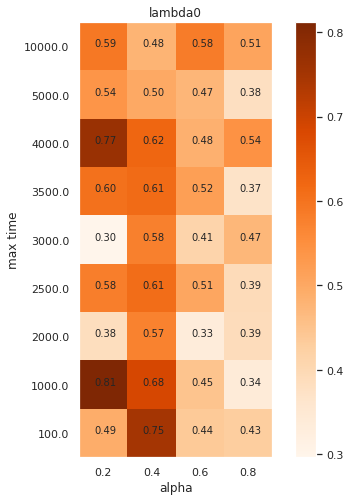

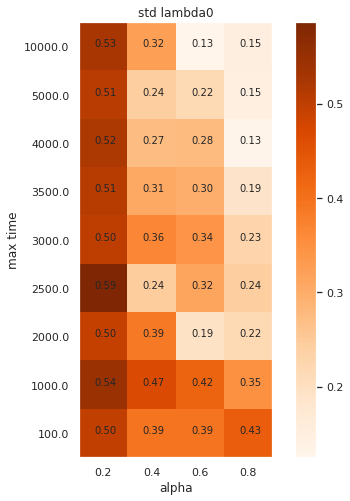

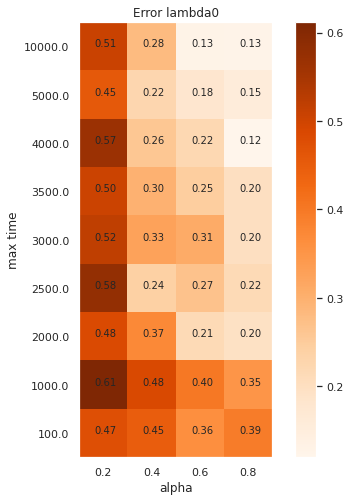

In [6]:
with open('results.pkl', 'rb') as fi:
    pkl_results = pickle.load(fi)

set_max_time = set()
set_alpha = set()
for res in pkl_results:
    set_max_time.add(res['max_time'])
    set_alpha.add(res['alpha'])
list_max_time = sorted(set_max_time, reverse=True)
list_alpha = sorted(set_alpha)

mat = np.zeros((len(list_max_time), len(list_alpha)))
err_mat = np.zeros_like(mat)
std_mat = np.zeros_like(mat)
n_mat = np.zeros_like(mat)
for i, max_time in enumerate(list_max_time):
    for j, alpha0 in enumerate(list_alpha):
        for res in pkl_results:
            if res['max_time'] == max_time and res['alpha'] == alpha0:
                mat[i, j] += res['theta'][-1]  # lambda0
                err_mat[i, j] += np.abs(noise - res['theta'][-1])  # Error on lambda0
                std_mat[i, j] += res['theta'][-1]**2
                n_mat[i, j] += 1
mat /= n_mat
err_mat /= n_mat
std_mat = np.sqrt(std_mat/n_mat - mat**2)

def plot_mat(m, title=''):
    plt.figure(figsize=(8,)*2)
    plt.imshow(m, cmap='Oranges')
    plt.colorbar()
    plt.grid(False)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(j-.18, i, f'{m[i, j]:.2f}')
    plt.xticks(range(len(list_alpha)), labels=list_alpha)
    plt.yticks(range(len(list_max_time)), labels=list_max_time)
    plt.xlabel('alpha')
    plt.ylabel('max time')
    plt.title(title)

plot_mat(mat, 'lambda0')
plot_mat(std_mat, 'std lambda0')
plot_mat(err_mat, 'Error lambda0')

In [8]:
for i, max_time in enumerate(list_max_time):
    for j, alpha0 in enumerate(list_alpha):
        print(f'max time: {max_time} / alpha0: {alpha0}')
        for res in pkl_results:
            if res['max_time'] == max_time and res['alpha'] == alpha0:
                print('   ', res['theta'][-1])  # lambda0

max time: 10000.0 / alpha0: 0.2
    1e-16
    1.13042708945865
    1.3418041843819046
    1e-16
    0.8746818235786916
    0.9479054357205273
    1e-16
max time: 10000.0 / alpha0: 0.4
    0.6670503276515252
    0.7886359968667945
    0.9408209120595361
    0.5059172185816807
    0.6033164356884516
    1e-16
    1e-16
max time: 10000.0 / alpha0: 0.6
    0.5563637671238508
    0.6461027218391955
    0.6642292015811859
    0.6968601287442637
    0.7864384584154062
    0.5663809781194706
    0.46015340930235393
max time: 10000.0 / alpha0: 0.8
    0.41182438967094276
    0.5418046189257688
    0.742632268020183
    0.5191540682245563
    0.4141604352938561
    0.6198746343379492
    0.7153048098130497
max time: 5000.0 / alpha0: 0.2
    1.324641183052168
    1e-16
    1e-16
    1.2729153684463594
    0.7252736484399128
    0.6868887379130176
    0.4089641373839995
    0.947830318888939
    1e-16
    1e-16
max time: 5000.0 / alpha0: 0.4
    0.8624239895311705
    0.7823742317280503
    0.2255

In [9]:
pkl_results

[{'max_time': 100.0,
  'alpha': 0.2,
  'theta': array([5.33e-01, 6.41e-01, 9.82e-02, 1.00e-16, 1.03e+00]),
  'trial': 0},
 {'max_time': 100.0,
  'alpha': 0.4,
  'theta': array([0.6 , 0.  , 1.  , 1.33, 0.94]),
  'trial': 0},
 {'max_time': 100.0,
  'alpha': 0.6,
  'theta': array([0.56, 0.25, 1.  , 1.81, 1.01]),
  'trial': 0},
 {'max_time': 100.0,
  'alpha': 0.8,
  'theta': array([1.54e+00, 7.29e-01, 8.94e-01, 7.45e-01, 1.00e-16]),
  'trial': 0},
 {'max_time': 1000.0,
  'alpha': 0.2,
  'theta': array([0.43, 0.47, 0.48, 1.79, 0.99]),
  'trial': 0},
 {'max_time': 1000.0,
  'alpha': 0.4,
  'theta': array([0.54, 0.55, 0.78, 1.29, 0.88]),
  'trial': 0},
 {'max_time': 1000.0,
  'alpha': 0.6,
  'theta': array([1.48e+00, 1.45e+00, 3.96e-01, 1.31e+00, 1.00e-16]),
  'trial': 0},
 {'max_time': 1000.0,
  'alpha': 0.8,
  'theta': array([1.46e+00, 1.54e+00, 4.92e-01, 1.47e+00, 1.00e-16]),
  'trial': 0},
 {'max_time': 2000.0,
  'alpha': 0.2,
  'theta': array([1.45e+00, 1.54e+00, 1.10e-01, 1.49e+00, 1.00